# Практическое задание, семинар 9

В задании вы экспериментально выясните, почему глубокие деревья хорошо подходят для построения случайного леса. 

Мы будем пользоваться следующей методикой. Мы хотим установить, что семейство алгоритмов А обладает свойством Б. Мы находим в теории фрагмент, где описаны достаточные условия для выполнения условия Б, и проверяем, что А им удовлетворяет. 

Конкретно у нас: А - глубокие деревья, Б - эффективный бутстрап, он же бэггинг (эффективный - то есть показывающий хорошее качество), достаточное условие - некоррелированность ошибок базовых алгоритмов. Рассмотрим подробнее.

__Фрагмент теории про построение эффективных композиций.__

В [лекции 8](https://github.com/esokolov/ml-course-hse/blob/master/2017-fall/lecture-notes/lecture08-ensembles.pdf) в разделе про бутстрап было показано, что если у нас есть $N$ алгоритмов $b_1(x) \dots b_N(x)$, ошибки которых несмещены:
$$\mathbb{E}_x[b_j(x) - y(x)] = 0$$
и некоррелированы:
$$\mathbb{E}_x (b_i(x) - y(x))(b_j(x) - y(x)) = 0, i \ne j,$$
то матожидание ошибки композиции $b(x) = \sum_j b_j(x)$ в $N$ раз меньше, чем одного отдельного алгоритма. Перечитайте этот фрагмент лекции, если не очень понятно, о чем речь.

Несмещенность ошибок означает, что алгоритм с одинковой вероятностью ошибается в большую и меньшую сторону. Это условие обычно выполняется для всех алгоритмов (если мы только специально не задаем вес ошибок в какую-то из сторон больше при обучении). 

Коррелированность ошибок подразумевает, что если один алгоритм сильно ошибся на каком-то объекте, то и другой тоже сильно ошибется. Для построения эффективной композиции надо, чтобы это не выполнялось.

Попробуем разобраться, какие алгоритмы будут коррелированными, а какие - по крайней мере не сильно коррелированы.

Самый простой алгоритм - константа $b(x) = C$. Ясно, что несмещенный такой алгоритм можно построить только один: $C = \mathbb{E}_x y(x)$. С таким простым алгоритмом каши не сваришь.

Далее по простоте, наверно, идут решающие пни - деревья глубины один. Это почти константа, только в двух разных областях пространства ответов своя. Как вы думаете, будут ли коррелированы два решающих пня, обученных по разным подвыборкам? 

А если брать глубокие деревья?

Вроде бы пни - соссем несложная вещь, и интегралы с ними легко считаются (если выбрать какое-то распределениями над объектами и целевую зависимость), но понять, равен ли интеграл нулю, как-то быстро не получается. Зато можно проверить численно, чем мы и займемся.


__Постановка эксперимента.__

Итак, нам надо проверить, будут ли коррелировать ошибки деревьев, обученных по разным подвыборкам. И проверить это для деревьев разной глубины.

Возьмем датасет Бостон (регрессия стоимости жилья). Разделим на две части - по одной будем обучать алгоритмы, по другой - проверять ошибки. 

In [260]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.datasets import load_boston
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

In [228]:
def prediction_tree(max_d = None, rand_s = None):
    sample = np.random.randint(X_train.shape[0], size=X_train.shape[0])
    X_train_bootstrap = X_train[sample]
    y_train_bootstrap = y_train[sample]
    
    DT_clf = DecisionTreeRegressor(max_depth = max_d, random_state = rand_s) 
    DT_clf.fit(X_train_bootstrap, y_train_bootstrap)
    return DT_clf

In [229]:
data = load_boston()
data.keys()

['data', 'feature_names', 'DESCR', 'target']

In [300]:
X = data.data
y = data.target
print X.shape
print y.shape

(506, 13)
(506,)


In [231]:
# перемешайте датасет, возьмите первую половину объектов в обучение, вторую - в "контроль"
X, y = shuffle(X, y)
X_train = X[:X.shape[0] / 2]
X_test = X[X.shape[0] / 2 : ]
y_train = y[:X.shape[0] / 2]
y_test = y[X.shape[0] / 2 :]

Сначала реализуем процедуру бэггинга. Надо с помощью np.random.randint сгенерировать индексы объектов обучающей выборки (получится с повторениями, нам так и надо), выбрать соответствующие объекты и обучить на них дерево. Будем везде считать, что длина бустрапированной выборки совпадает с длиной исходной.

In [232]:
# обучите 2 одинаковых дерева (например, с настройками по умолчанию) по разным бутстрапированным выборкам
DT1 = prediction_tree()
DT2 = prediction_tree()

Теперь научимся оценивать смещенность и коррелированность.

__Теоретическая справка: приближенное вычисление интегралов__

Если нам нужно оценить математическое ожидание $\mathbb{E}_{x \sim p(x)} f(x) = \int f(x) p(x) dx$, то можно просемплировать выборку $\{x_1, \dots, x_n\}$ из распределения $p(x)$  и приближенно вычислить ннтеграл:
    $$
    \mathbb{E}_{x \sim p(x)} f(x) \approx \frac 1 n \sum_{i=1}^n f(x_i).
    $$
    Из областей с большим значением плотности в выборку попадет больше точек, и они внесут больший вклад в значение интеграла.
    
В нашем случае математическое ожидание берется по распределению над объектами $p(x)$. Ясно, что в жизни мы это распределение не знаем, однако выборка из этого распределения у нас есть, а именно она и нужна для приближенного оценивания.

Итак, надо посмотреть, какая функция стоит под мат. ожиданием, вычислить ее для всех точек из "контрольной" выборки и усреднить.

In [233]:
# оцените смещенность каждого из двух обученных деревьев, используя вторую ("контрольную") выборку
y_pred1 = DT1.predict(X_test)
np.mean((y_test - y_pred1))
#mean1 = np.sum(y_pred1) / (1.0 *y_pred1.shape[0])
#mean1

-0.47786561264822147

In [234]:
y_pred2 = DT2.predict(X_test)
np.mean((y_test - y_pred2))
#mean2 = np.sum(y_pred2) / (1.0 *y_pred2.shape[0])
#mean2

-0.17351778656126485

In [235]:
#mean1 - mean2

In [236]:
# оцените кореллированность двух деревьев, используя вторую ("контрольную") выборку
np.mean((y_test - y_pred1) * (y_test - y_pred2))

11.777430830039528

Получилось ли, что смещение практически нулевое, как мы и ожидали? Или хотя бы близко к нулю? Как вы думаете, почему так происходит? 

смещение достаточно близко к нулю, однако ковариация далека от нуля

__Эксперимент.__

Итак, теперь мы можем попробовать выяснить ответ на наш вопрос: как меняется уровень коррелированности деревьев при увеличении глубины. Рассмотрите пары одинаковых деревьев глубины [1, 2, 3, 4, 5], обученных по разным подвыборкам, и оцените их коррелированность. Чтобы результат был менее шумным, можно для каждого значения глубины обучать несколько пар деревьев и усреднять значение корреляции. Напечатайте или постройте график корреляция - глубина дерева. Получился ли он убывающим? Дошел ли уровень корреляции до нуля?

In [349]:
e1 = []
e2 = []
corr = []
for i in np.arange(1, 15):
    DT1 = prediction_tree(max_d=i, rand_s = i)
    y_pred1 = DT1.predict(X_test)
    e1.append(np.mean((y_test - y_pred1)))
    
    DT2 = prediction_tree(max_d=i, rand_s = i)
    y_pred2 = DT2.predict(X_test)
    e2.append(np.mean((y_test - y_pred2)))
    
    corr.append(np.mean((y_test - y_pred1) * (y_test - y_pred2)))

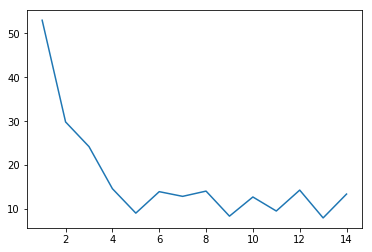

In [350]:
plt.plot(np.arange(1,15), corr)
plt.show()

__Еще один эксперимент.__

В лекции говорилось, что чем меньше корреляция, тем лучше должно быть качество композиции. График корреляции мы построили, теперь надо сравнить его с графиком качества. 

Используя всю перемешанную выборку boston, постройте графиков MSE - глубина дерева на кросс-валидации с треми блоками. Реализация кросс-валдиации - cross_val_score или GridSearchCV на ваше усмотрение. Вроде как в данной ситуации проще использовать cross_val_score и цикл по глубине дерева.

In [301]:
from sklearn.model_selection import cross_val_score # использовать scoring="neg_mean_squared_error"
DT = prediction_tree()

In [353]:
losses = []
#for i in range(1, 15):
#    DT = prediction_tree(max_d=i)
#    loss = np.sum(np.abs(cross_val_score(DT, X, y, cv = 3, scoring="neg_mean_squared_error")))
#    losses.append(loss)
       
losses = []
corr = []
for i in np.arange(1, 15):
    DT1 = prediction_tree(max_d=i, rand_s = i)
    
    loss = np.sum(np.abs(cross_val_score(DT, X, y, cv = 3, scoring="neg_mean_squared_error")))
    losses.append(loss)
    
    y_pred1 = DT1.predict(X_test)
    DT2 = prediction_tree(max_d=i, rand_s = i)
    y_pred2 = DT2.predict(X_test)
    corr.append(np.mean((y_test - y_pred1) * (y_test - y_pred2)))
    

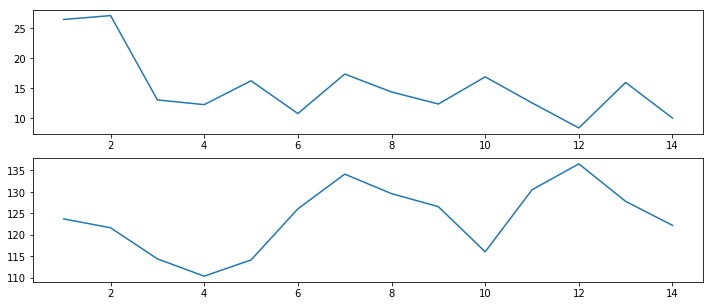

In [354]:
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

ax1.plot(np.arange(1,15), corr)
ax2.plot(np.arange(1,15), losses)
plt.show()

Если у вас еще осталось время, то теперь мега-челендж: оформите свой код так, чтобы в нем почти не было копипаста.

Если у вас все еще осталось время (и желание), то можете теперь аналогично поэкспериментировать с параметром max_features, рассмотрев все возможные его значения для задачи Бостон (от 1 до 13).